In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix

from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch

from data_utils import DataUtils

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'data/mtsamples.csv'
MODEL_TYPE = 'roberta'
MODEL_NAME = 'roberta-base'

In [4]:
df = pd.read_csv(DATASET_PATH, usecols=['keywords', 'transcription', 'medical_specialty'])    
df.head()

,medical_specialty,transcription,keywords
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
utils = DataUtils()
df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)

df['medical_specialty'] = df['medical_specialty'].str.strip()

===== Null Summary =====
medical_specialty       0
transcription          33
keywords             1068
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 0


===== Class Distribution =====
medical_specialty
Surgery                          1021
other                             888
Orthopedic                        303
Cardiovascular / Pulmonary        280
Radiology                         251
Consult - History and Phy.        234
Gastroenterology                  195
Neurology                         168
General Medicine                  146
SOAP / Chart / Progress Notes     142
Urology                           140
Obstetrics / Gynecology           130
Name: count, dtype: int64


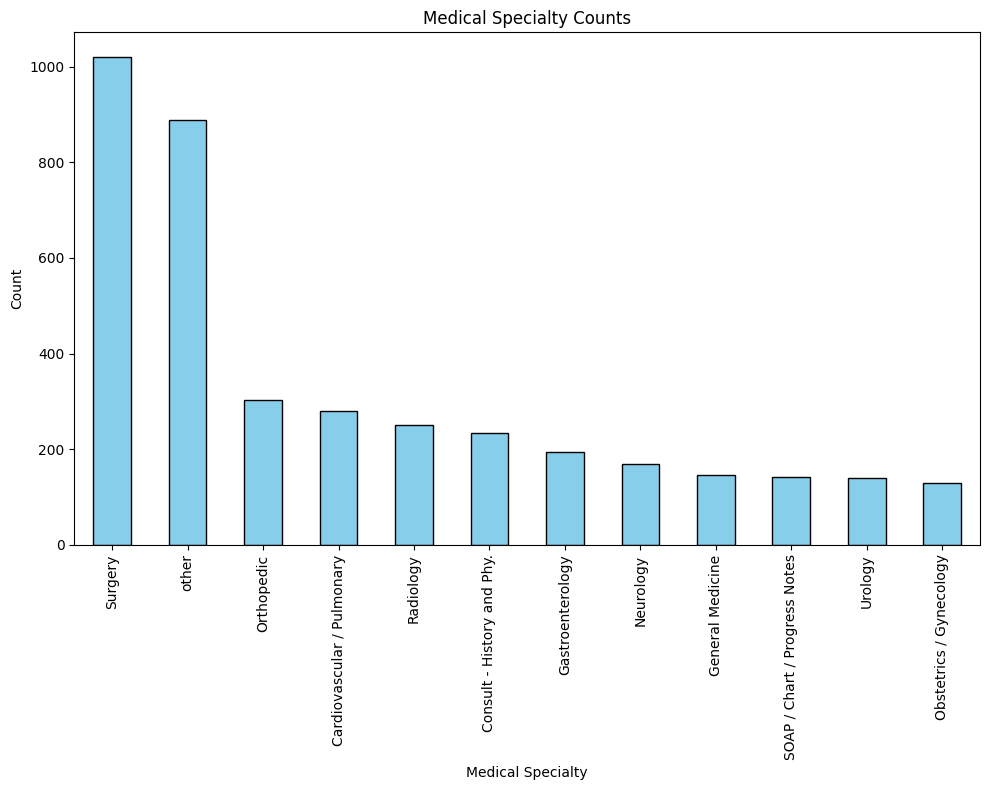

In [6]:
speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: x if speciality_count[x] >= MIN_SPECIALITY_THRESHOLD else 'other')
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)

In [7]:
df['label'], uniques = pd.factorize(df["medical_specialty"])
print("Unique medical specialties:")
for i, label in enumerate(uniques):
    print(f"{i}: {label}")

df.sample(5, random_state=42)

Unique medical specialties:
0: other
1: Cardiovascular / Pulmonary
2: Urology
3: General Medicine
4: Surgery
5: SOAP / Chart / Progress Notes
6: Radiology
7: Orthopedic
8: Obstetrics / Gynecology
9: Neurology
10: Gastroenterology
11: Consult - History and Phy.


,medical_specialty,transcription,keywords,label
4700,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION:, Pneumothorax and su...","cardiovascular / pulmonary, trauma, tracheobro...",1
988,Surgery,"PREPROCEDURE DIAGNOSIS: , Colon cancer screeni...","surgery, colon polyps, diverticulosis, hemorrh...",4
346,Surgery,"PREOPERATIVE DIAGNOSIS: , Shunt malfunction. ...","surgery, ventriculoatrial shunt, endoscopic pr...",4
2384,other,"PREOPERATIVE DIAGNOSIS:, Ruptured globe with ...","ophthalmology, ruptured globe, alphagan, bss, ...",0
1628,Radiology,"EXAM: , Digital screening mammogram.,HISTORY:,...","radiology, mediolateral, craniocaudal, fibrogl...",6


In [8]:
dataset = pd.DataFrame({
    'text' : df['keywords']+df['transcription'],
    'label' : df['label']
})

train_df, test_df = train_test_split(dataset, test_size=DS_SPLIT, stratify=dataset['label'], random_state=42)
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")


Train Shape: (3118, 2), Test Shape: (780, 2)


In [9]:
def compute_metrics(pred, actual):
    return {
        "accuracy": balanced_accuracy_score(actual, pred),
        "f1_weighted": f1_score(actual, pred, average="weighted")
    }

In [10]:
cuda_available = torch.cuda.is_available()
num_classes = len(uniques)

model_args = ClassificationArgs(
    num_train_epochs=10,
    learning_rate=1e-5,
    reprocess_input_data=True,
    save_model_every_epoch=False,
    overwrite_output_dir= True,
    use_early_stopping=True,
    early_stopping_patience=2,
    early_stopping_metric="mcc",
    early_stopping_delta=0.005
)

model = ClassificationModel(
    MODEL_TYPE,
    MODEL_NAME,
    num_labels=num_classes,
    weight=[1]*num_classes,
    use_cuda=cuda_available,
    args=model_args
)

model.train_model(train_df, eval_df=test_df, custom_eval_function=compute_metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

(3900, 0.17877725064539565)

In [11]:
eval_result, _, _ = model.eval_model(test_df)
y_pred, _ = model.predict(test_df['text'].values.tolist())
pred_result = compute_metrics(y_pred, test_df['label'])

print(f"MCC: {eval_result['mcc']}, Eval_Loss: {eval_result['eval_loss']}")
print(f"Accuracy: {pred_result['accuracy']}, F1 Score: {pred_result['f1_weighted']}")

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

MCC: 0.977430680409649, Eval_Loss: 0.11797123815631494
Accuracy: 0.9777674053672097, F1 Score: 0.9808149923175079


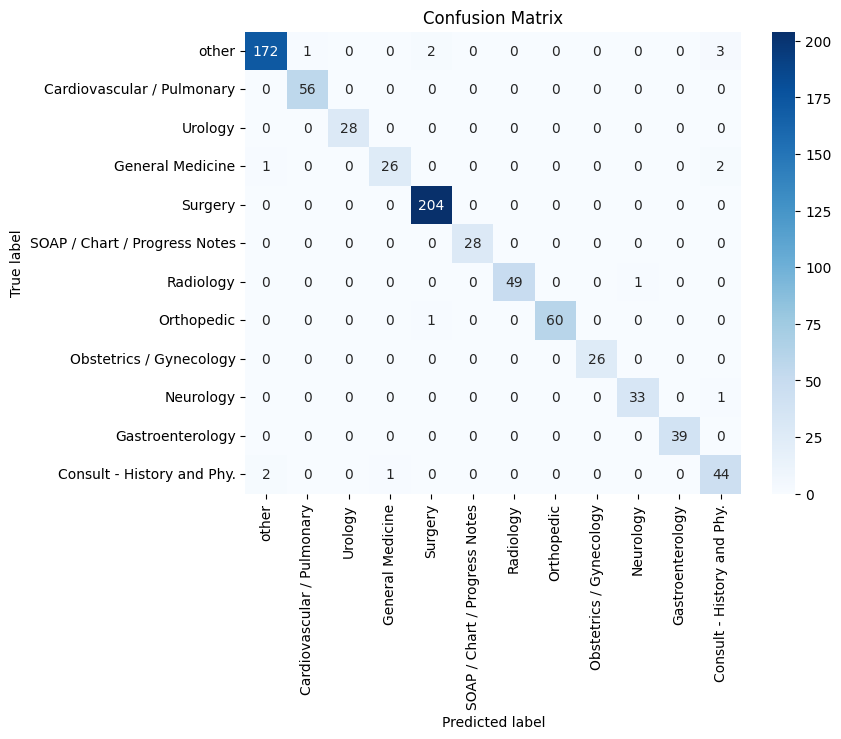

In [12]:
classes = [uniques[i] for i in range(len(uniques))]
cm = confusion_matrix(test_df['label'], y_pred)
utils.plot_confusion_matrix(cm, classes)

In [13]:
samples = pd.DataFrame()
for i in range(len(uniques)):
    sample = test_df[test_df.label == i].sample(1, random_state=21)
    samples = pd.concat([samples, sample])

samples = samples.reset_index(drop=True)
samples = samples.rename(columns={'label': 'true_label'})
samples['predicted_label'], _ = model.predict(samples['text'].tolist())
samples

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,text,true_label,predicted_label
0,"podiatry, debrided, nails, dystrophic nails, d...",0,0
1,"cardiovascular / pulmonary, ventricular arrhyt...",1,1
2,"urology, iodine-125 seed implantation, seed im...",2,2
3,"general medicine, swelling, iv hydration, oste...",3,3
4,"surgery, posterolateral chest, stab wound, lid...",4,4
5,"soap / chart / progress notes, jak-2 positive ...",5,5
6,"radiology, coronary artery cta, calcium scorin...",6,6
7,"orthopedic, painful right knee, total knee art...",7,7
8,"obstetrics / gynecology, dilatation and curett...",8,8
9,"neurology, alpha activity, wave activity, hype...",9,9


Rajapakse, T. C., Yates, A., & de Rijke, M. (2024). Simple Transformers: Open-source for all. In *Proceedings of the 2024 Annual International ACM SIGIR Conference on Research and Development in Information Retrieval in the Asia Pacific Region* (SIGIR-AP 2024, pp. 209–215). Association for Computing Machinery. [https://doi.org/10.1145/3673791.3698412](https://doi.org/10.1145/3673791.3698412)